In [3]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Reading Data

In [4]:
warnings.filterwarnings("ignore")

obs_start = '2020-01-01'; obs_end = '2023-12-31'
sessions = (
    pd.read_csv('../../data/sessions.csv', parse_dates=['event_date'])
      .query('event_date >= @obs_start and event_date <= @obs_end')
)
transactions = (
    pd.read_csv('../../data/transactions.csv', parse_dates=['event_date'])
     .query('event_date >= @obs_start and event_date <= @obs_end')
    )
prod_cat = pd.read_csv("../../data/product_categories.csv")

## Preprocessing

### Filter out sessions and transactions related to amazon.com

In [5]:
# filter sessions
is_amz = sessions['domain_name'].str.contains('amazon', case=False, na=False)
sessions_amz     = sessions[is_amz]
sessions_non_amz = sessions[~is_amz]

# filter transactions
is_amz_tx = transactions['domain_name'].str.contains('amazon', case=False, na=False)
transactions_amz     = transactions[is_amz_tx]
transactions_non_amz = transactions[~is_amz_tx]


### Removing Duplicate Entries

In [6]:
sessions_amz = sessions_amz.drop_duplicates().reset_index()
sessions_non_amz = sessions_non_amz.drop_duplicates().reset_index()
transactions_amz = transactions_amz.drop_duplicates().reset_index()
transactions_non_amz = transactions_non_amz.drop_duplicates().reset_index()

### Convert the 'event_date' columns in transactions_amz and sessions_amz to datetime format.

In [7]:
transactions_amz['event_date'] = pd.to_datetime(transactions_amz['event_date'])
sessions_amz['event_date'] = pd.to_datetime(sessions_amz['event_date'])

### Group transactions by machine_id, sort by event_date, and compute recency in days as the interval between consecutive transactions.

In [8]:
grp = transactions_amz.groupby('machine_id')

transactions_amz = transactions_amz.sort_values(['machine_id','event_date'])

transactions_amz['prev_ts'] = grp['event_date'].shift(1)

transactions_amz['recency'] = (transactions_amz['event_date'] - transactions_amz['prev_ts']).dt.days.fillna(0).astype(int)

### Aggregate user-level ***frequency***, ***monetary***, ***recency***, and ***demographic*** metrics by merging sessions and transaction data.

In [9]:
# last purchase date per user

# last_purchase = (transactions_amz
#   .groupby('machine_id')['event_date']
#   .max()
#   .reset_index()
#   .rename(columns={'event_date':'last_purchase'}))

# today = max date in your training window, e.g. '2023-12-31'
# today = pd.to_datetime('2023-12-31')

# Recency
# last_purchase['recency'] = (today - pd.to_datetime(last_purchase['last_purchase'])).dt.days

# Frequency & Monetary & Behavior & Demographics
agg = (
    sessions_amz.groupby('machine_id')
    .agg(
      freq_sessions=('event_date','nunique'),
      avg_pages=('pages_viewed','mean'),
      avg_duration=('duration','mean')
      # Monetary: need to merge basket_tot from transactions_amz
    )
    .reset_index()
)

# Merge monetary
first_basket = (
    transactions_amz
    .groupby(['machine_id','event_date'], as_index=False)
    .agg(basket_tot=(
        'basket_tot',
        lambda x: x.dropna().iloc[0] if x.dropna().any() else np.nan
    ),
    recency=(
        'recency', 'first'
    ))
)

# 2) Now average those basket totals per machine
monetary = (
    first_basket
    .groupby('machine_id', as_index=False)
    .agg(avg_basket=('basket_tot','mean'),
         avg_recency=('recency', lambda x: x.sum()/(x.count() - 1) if x.count() > 1 else 0))
)

# Demographics
demo = (
    sessions_amz.sort_values('event_date')
    .groupby('machine_id')
    .first()[['hoh_most_education','household_income','household_size','census_region','racial_background']]
    .reset_index()
)

# Final user‑table
user_amz = (agg
    .merge(monetary, on='machine_id')
    .merge(demo, on='machine_id'))


In [10]:
user_amz.head(10)

,machine_id,freq_sessions,avg_pages,avg_duration,avg_basket,avg_recency,hoh_most_education,household_income,household_size,census_region,racial_background
0,95674009,1,37.000000,20.000000,27.160000,0.000000,-88.0,15.0,5.0,2.0,1.0
1,100026976,22,13.040000,7.240000,96.137500,84.000000,-88.0,15.0,3.0,3.0,1.0
2,100419233,13,8.000000,9.000000,27.720000,34.500000,-88.0,13.0,2.0,1.0,1.0
3,100608415,4,3.250000,3.500000,53.034722,8.560976,-88.0,14.0,5.0,2.0,1.0
4,104340822,62,12.542857,14.742857,247.011429,93.166667,-88.0,13.0,2.0,1.0,1.0
5,104679635,37,10.047619,7.357143,47.249091,27.700000,-88.0,14.0,2.0,4.0,1.0
6,106972486,29,18.419355,22.451613,146.874286,16.333333,-88.0,13.0,1.0,3.0,1.0
7,124076587,16,26.470588,23.176471,19.755000,185.333333,-88.0,15.0,4.0,1.0,1.0
8,124897396,6,6.750000,9.500000,76.195000,194.000000,-88.0,12.0,4.0,3.0,1.0
9,124986872,5,11.200000,9.600000,101.390000,113.000000,-88.0,14.0,5.0,4.0,1.0


In [11]:
sessions_amz[sessions_amz['machine_id'] == 124986872]

,index,machine_id,site_session_id,user_session_id,domain_id,ref_domain__name,pages_viewed,duration,event_date,event_time,...,census_region,household_size,hoh_oldest_age,household_income,children,racial_background,connection_speed,hispanic,zip_code,domain_name
6698326,11205704,124986872,562060102610139807,2731249868720005,4.046670e+18,facebook.com,1.0,1.0,2022-09-11,21:40:54,...,4.0,5.0,11.0,14.0,0.0,1.0,1.0,0.0,98501.0,amazon.com
6804039,11378066,124986872,2439152109371607300,2741249868720003,4.046670e+18,amazon.com,15.0,16.0,2022-10-07,13:16:34,...,4.0,5.0,NaN,14.0,0.0,1.0,1.0,0.0,98501.0,amazon.com
7249366,12104986,124986872,427694971436196994,2771249868720005,4.046670e+18,amazon.com,9.0,6.0,2023-01-26,0:16:20,...,4.0,5.0,11.0,14.0,0.0,1.0,1.0,0.0,98501.0,amazon.com
7257423,12118320,124986872,7316005985264953817,2771249868720006,4.046670e+18,NaN,19.0,23.0,2023-01-28,21:32:29,...,4.0,5.0,11.0,14.0,0.0,1.0,1.0,0.0,98501.0,amazon.com
7620100,12721961,124986872,5122913923999086979,2821249868720002,4.046670e+18,NaN,12.0,2.0,2023-06-01,20:15:45,...,4.0,5.0,11.0,14.0,0.0,1.0,NaN,0.0,98501.0,amazon.com


In [12]:
transactions_amz[transactions_amz['machine_id'] == 124986872]

,index,machine_id,site_session_id,prod_category_id,prod_name,domain_id,prod_qty,prod_totprice,basket_tot,event_date,event_time,domain_name,total_transactions_2020,total_transactions_2021,total_transactions_2022,total_transactions_2023,prev_ts,recency
1246333,1906276,124986872,0,7009031113,"Altered park Portable Air Conditioner Fan, Per...",4.046670e+18,1.0,39.99,138.15,2022-10-07,13:28:03,amazon.com,NaN,NaN,5.0,4.0,NaT,0
1246334,1906277,124986872,0,7008027182,Ol' Roy Dog food Soft & Moist Beef & Cheese Fl...,4.046670e+18,4.0,77.00,138.15,2022-10-07,13:28:03,amazon.com,NaN,NaN,5.0,4.0,2022-10-07,0
1313727,2034564,124986872,0,999,"Monday, Jan. 30",4.046670e+18,1.0,0.00,64.63,2023-01-28,21:36:33,amazon.com,NaN,NaN,5.0,4.0,2022-10-07,113
1313728,2034565,124986872,0,7008023051,RESTECK Massagers for Neck and Back with Heat ...,4.046670e+18,1.0,59.95,64.63,2023-01-28,21:36:33,amazon.com,NaN,NaN,5.0,4.0,2023-01-28,0
1313731,2034568,124986872,0,7008023051,RESTECK Massagers for Neck and Back with Heat ...,4.046670e+18,2.0,119.90,109.96,2023-01-28,21:47:55,amazon.com,NaN,NaN,5.0,4.0,2023-01-28,0


In [13]:
user_amz['hoh_most_education'] = user_amz['hoh_most_education'].replace(-88, 99)
user_amz['household_size'] = user_amz['household_size'].replace(-88, 99)

In [14]:
user_amz_final = user_amz.dropna().reset_index(drop=True)

### Scaling and Encoding Features

In [15]:
user_amz_pre = user_amz_final.copy()

# 2. Scale numeric features
numeric_cols = ['avg_recency', 'freq_sessions', 'avg_pages', 'avg_duration', 'avg_basket']
scaler = StandardScaler()
user_amz_pre[numeric_cols] = scaler.fit_transform(user_amz_pre[numeric_cols])

# 3. One-hot encode demographic features
demo_cols = ['hoh_most_education', 'household_income', 'household_size', 'census_region', 'racial_background']
user_amz_pre = pd.get_dummies(user_amz_pre, columns=demo_cols, prefix=demo_cols)

In [16]:
X = user_amz_pre.drop(columns=['machine_id'], errors='ignore')

In [17]:
X.columns

Index(['freq_sessions', 'avg_pages', 'avg_duration', 'avg_basket',
       'avg_recency', 'hoh_most_education_1.0', 'hoh_most_education_2.0',
       'hoh_most_education_3.0', 'hoh_most_education_4.0',
       'hoh_most_education_5.0', 'hoh_most_education_99.0',
       'household_income_11.0', 'household_income_12.0',
       'household_income_13.0', 'household_income_14.0',
       'household_income_15.0', 'household_income_16.0',
       'household_income_17.0', 'household_income_18.0', 'household_size_1.0',
       'household_size_2.0', 'household_size_3.0', 'household_size_4.0',
       'household_size_5.0', 'household_size_99.0', 'census_region_1.0',
       'census_region_2.0', 'census_region_3.0', 'census_region_4.0',
       'census_region_99.0', 'racial_background_1.0', 'racial_background_2.0',
       'racial_background_3.0', 'racial_background_5.0',
       'racial_background_99.0'],
      dtype='object')

### Calculating interia for different k values for the ELBOW Method

In [18]:
inertias = []
Ks = range(2, 11)
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

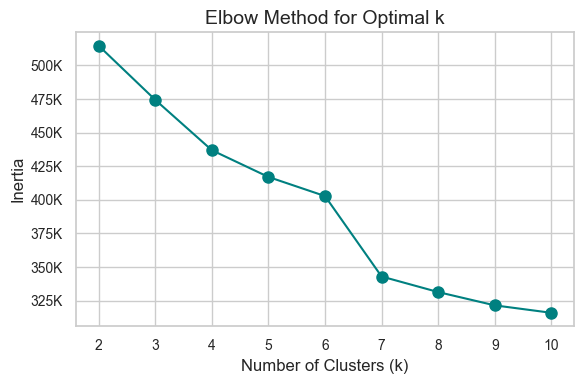

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 4))

plt.plot(Ks, inertias, marker='o', linestyle='-', color='teal', markersize=8)

plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))

plt.tight_layout()
plt.savefig("elbow_score.png", dpi = 300)
plt.show()


### Calculating silhoutte score for different k values for the Silhoutte Method

In [20]:
sil_scores = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))

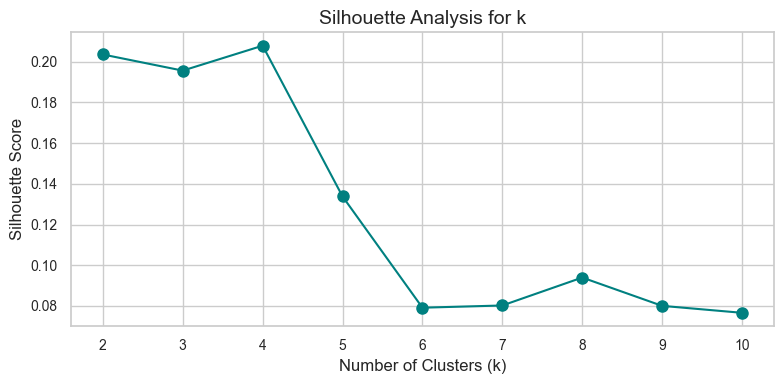

In [21]:

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 4))

plt.plot(Ks, sil_scores, marker='o', linestyle='-', color='teal', markersize=8)

plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Analysis for k', fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


plt.tight_layout()
plt.savefig("sil_k.png", dpi = 300)

plt.show()


### Best Cluster

In [22]:
best_k = 4  # replace with the k you select from the elbow/silhouette plots
kmeans = KMeans(n_clusters=best_k, random_state=42)
user_amz_final['cluster'] = kmeans.fit_predict(X)

In [23]:
user_amz_final["cluster"].value_counts()

cluster
1    48274
3     7597
2     5925
0     4314
Name: count, dtype: int64

### Visualizing Different Behavioral Metrics per cluster

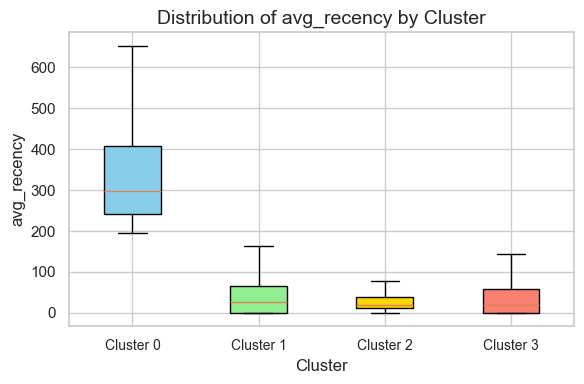

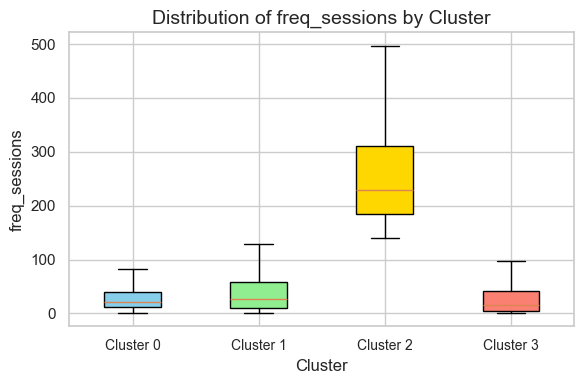

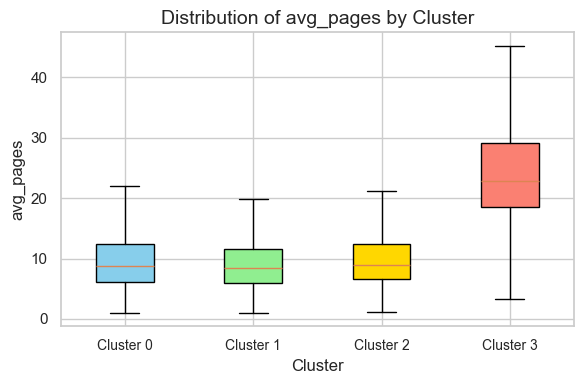

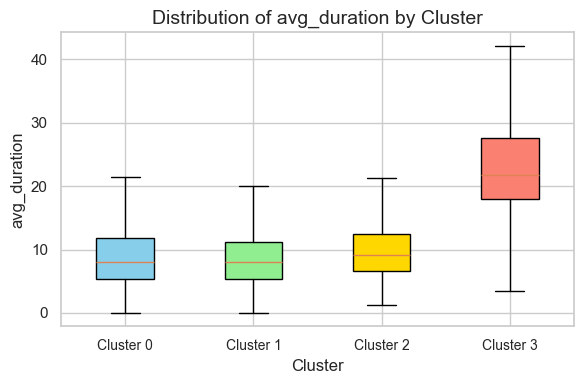

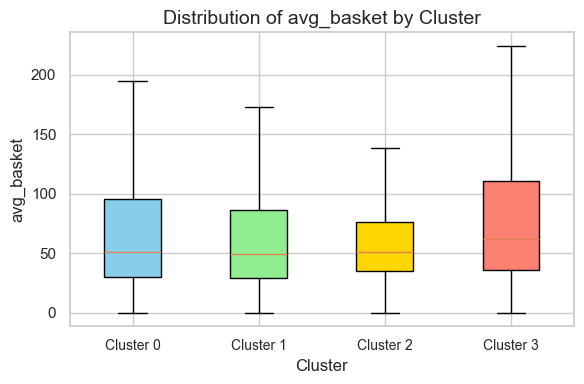

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

numeric_cols = ['avg_recency', 'freq_sessions', 'avg_pages', 'avg_duration', 'avg_basket']

colors = ['skyblue', 'lightgreen', 'gold', 'salmon']

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    
    data = [user_amz_final[user_amz_final['cluster'] == k][col] for k in range(4)]
    
    bp = plt.boxplot(data, patch_artist=True, showfliers=False)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.xticks(range(1, 5), [f'Cluster {k}' for k in range(4)], fontsize=10)
    
    plt.title(f'Distribution of {col} by Cluster', fontsize=14)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(col, fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f"boxplot_{col}.png", dpi=300)
    plt.show()
    
    plt.close()


### Violin Plots

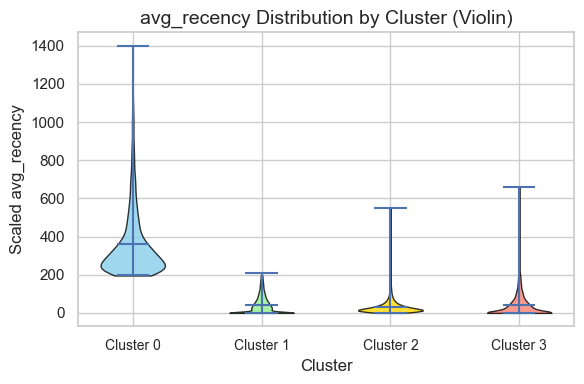

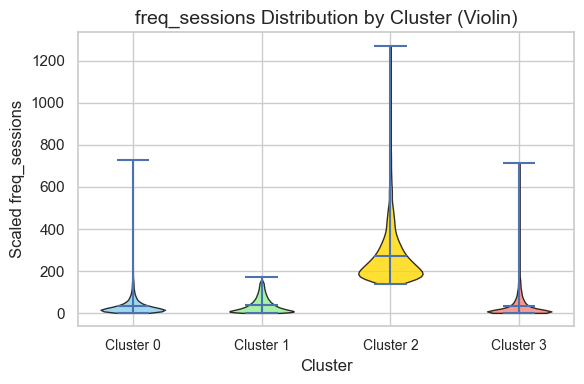

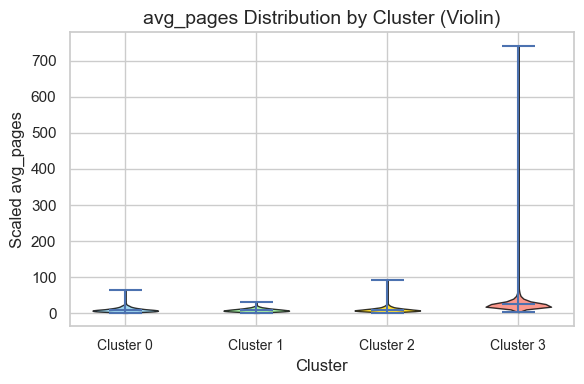

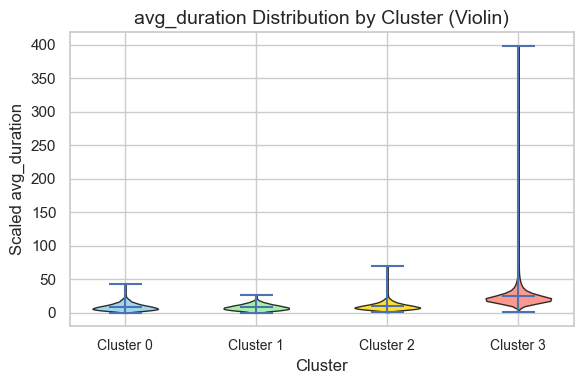

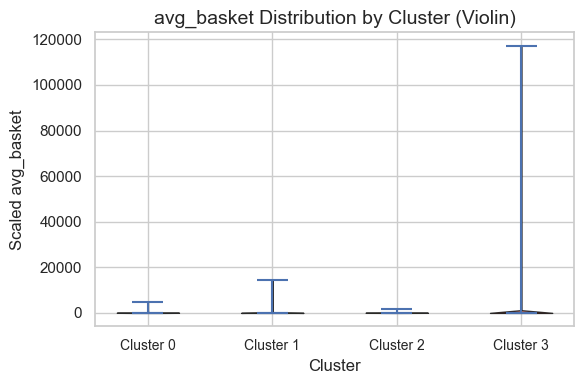

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

numeric_cols = ['avg_recency', 'freq_sessions', 'avg_pages', 'avg_duration', 'avg_basket']

colors = ['skyblue', 'lightgreen', 'gold', 'salmon']

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    
    data = [user_amz_final[user_amz_final['cluster'] == k][col] for k in range(4)]
    
    parts = plt.violinplot(data, showmeans=True)
    
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(0.8)
    
    plt.xticks([1, 2, 3, 4], [f'Cluster {k}' for k in range(4)], fontsize=10)
    
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(f'Scaled {col}', fontsize=12)
    plt.title(f'{col} Distribution by Cluster (Violin)', fontsize=14)
    
    plt.tight_layout()
plt.show()


### Cluser 0 ( Dormant)
- haven’t bought in a long time; light site use; mid‑sized orders.
- These users rarely return and haven’t made a purchase in a long time. When they do visit, they browse a handful of pages and make average‑sized orders before leaving.

### Cluser 1 (Occasional Buyers)
- recent but infrequent purchasers; brief visits; average spend.
-  They pop in and out: a purchase every few weeks with brief, straightforward sessions. Their engagement and spend are unremarkable but consistent.

### Cluser 2 (Frequent Browsers)
- come back often but skim pages; average basket size.
- They’re on the site all the time—many short visits—but tend to skim content and make only average‑sized purchases. High frequency, low commitment.

### Cluser 3 (Engaged Spenders)
-  deep, lengthy sessions; larger baskets; loyal recent buyers.
- These users dive deep: long sessions, many pages per visit, and the largest baskets. They’re loyal shoppers who research thoroughly before buying.

In [26]:
for col in demo_cols:
    ct = pd.crosstab(user_amz_final['cluster'], user_amz_final[col], normalize='index')  # % within each cluster
    print(f"\nDistribution of {col} by cluster:\n", ct)


Distribution of hoh_most_education by cluster:
 hoh_most_education      1.0       2.0       3.0       4.0       5.0       99.0
cluster                                                                       
0                   0.011127  0.124478  0.151599  0.145109  0.022717  0.544970
1                   0.011062  0.137030  0.169180  0.151779  0.025293  0.505655
2                   0.012996  0.207257  0.236793  0.236287  0.043882  0.262785
3                   0.015927  0.132947  0.154798  0.111755  0.013163  0.571410

Distribution of household_income by cluster:
 household_income      11.0      12.0      13.0      14.0      15.0      16.0  \
cluster                                                                        
0                 0.173389  0.138387  0.161335  0.073482  0.120306  0.147659   
1                 0.168787  0.134565  0.157704  0.084973  0.118325  0.163649   
2                 0.135696  0.116793  0.177046  0.111392  0.144810  0.188354   
3                 0.201395  0.

### Demographic Distribution visualization within each cluster

<Figure size 600x400 with 0 Axes>

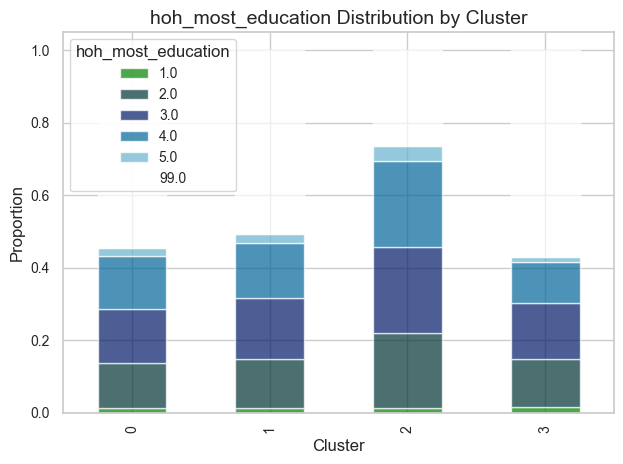

<Figure size 600x400 with 0 Axes>

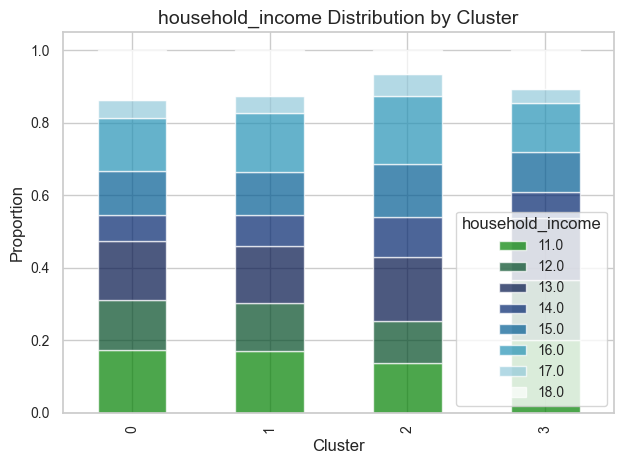

<Figure size 600x400 with 0 Axes>

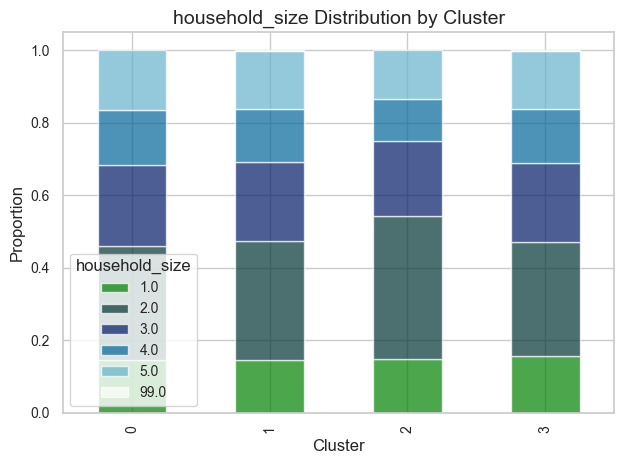

<Figure size 600x400 with 0 Axes>

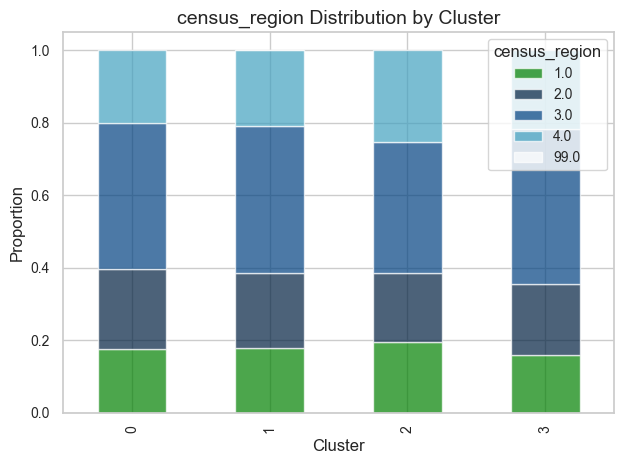

<Figure size 600x400 with 0 Axes>

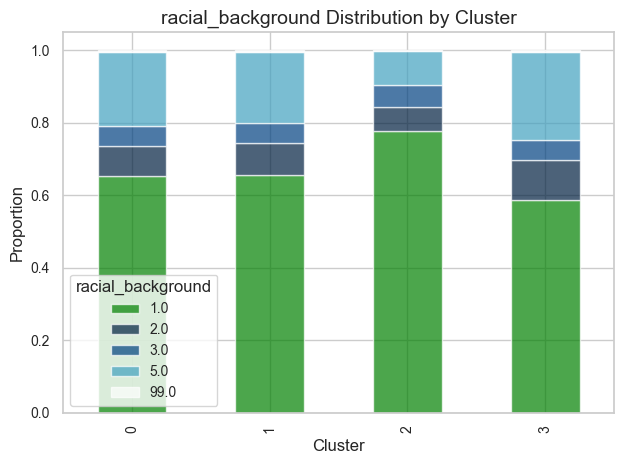

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

for col in demo_cols:
    dist = user_amz_final.groupby(['cluster', col]).size().unstack(fill_value=0)
    dist = dist.div(dist.sum(axis=1), axis=0)
    
    plt.figure(figsize=(6, 4))
    
    dist.plot(kind='bar', 
              stacked=True, 
              colormap='ocean', 
              legend=True, 
              fontsize=10, 
              alpha = 0.7)
    
    plt.title(f"{col} Distribution by Cluster", fontsize=14)
    plt.xlabel("Cluster", fontsize=12)
    plt.ylabel("Proportion", fontsize=12)
    
    plt.legend(title=col, fontsize=10, title_fontsize=12, loc="best")
    
    plt.xticks(fontsize=10)
    plt.tight_layout()
    
    plt.show()


In [28]:
from scipy.stats import chi2_contingency

for col in demo_cols:
    table = pd.crosstab(user_amz_final['cluster'], user_amz_final[col])
    chi2, p, _, _ = chi2_contingency(table)
    print(f"{col}: χ²={chi2:.1f}, p={p:.3f}")


hoh_most_education: χ²=1630.2, p=0.000
household_income: χ²=546.3, p=0.000
household_size: χ²=161.1, p=0.000
census_region: χ²=128.3, p=0.000
racial_background: χ²=695.1, p=0.000


### Considering only RFM features
- Using only Customer behaviour features shows equivalent performance as when using both RFM and Demo features, implying Customer behaviour features capture the demographic patterns as well.  

In [29]:
X2 = user_amz_pre.drop(columns=['machine_id'] + demo_cols, errors='ignore')

In [30]:
inertias = []
Ks = range(2, 11)
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X2)
    inertias.append(km.inertia_)

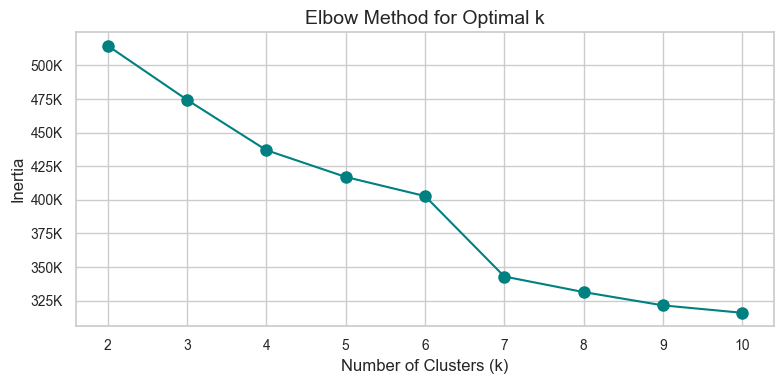

In [31]:

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 4))

plt.plot(Ks, inertias, marker='o', linestyle='-', color='teal', markersize=8)

plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.savefig("elbow_k.png", dpi = 300)
plt.show()


In [32]:
sil_scores = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X2)
    sil_scores.append(silhouette_score(X2, labels))

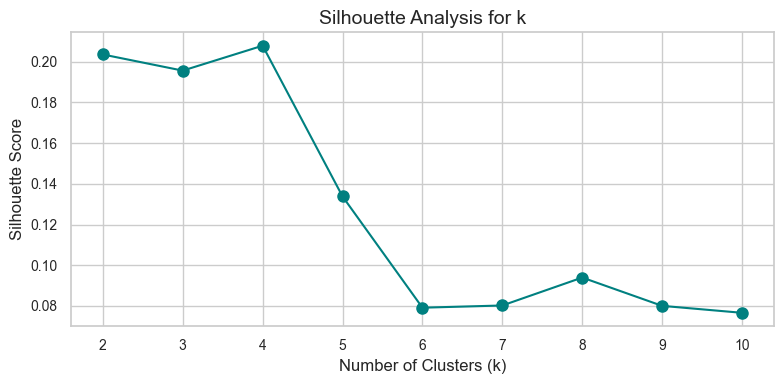

In [33]:

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 4))

plt.plot(Ks, sil_scores, marker='o', linestyle='-', color='teal', markersize=8)

plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Analysis for k', fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


plt.tight_layout()
plt.savefig("sil_k.png", dpi = 300)

plt.show()


In [34]:
df = user_amz_final.copy()
best_k = 4  # replace with the k you select from the elbow/silhouette plots
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X2)

In [35]:
df["cluster"].value_counts()

cluster
1    48274
3     7597
2     5925
0     4314
Name: count, dtype: int64